# Firefighters - Lieutenant

In [738]:
position = 'Lieutenant'
thresh = {'Lieutenant': (8, 16), 'Captain': (7,8)}
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

## Load the data

In [739]:
import numpy as np
import pandas as pd

def get_top_scoring(df, n):
    thresh = min(df['Combine'].nlargest(n+2))
    return df.apply(lambda x: x['Combine']>=thresh, axis=1)

def get_features(df, top_k_thresh):
    passed = df['Combine'].apply(lambda x: int(x >= 70)).rename('Passed')
    top_scoring = get_top_scoring(df, top_k_thresh[0]).rename('Top_k')
    top_scoring_2y = get_top_scoring(df, top_k_thresh[1]).rename('Top_k_2y')
    return pd.concat([top_scoring, top_scoring_2y, passed, df], axis=1)

data = pd.read_csv('../data/Firefighters.csv')  # load data set
data = data[data['Position']==position]
data.drop(['Position'],axis=1,inplace=True)
data = get_features(data, thresh[position])
data.head(5)

,Top_k,Top_k_2y,Passed,Race,Oral,Written,Combine
41,True,True,1,W,88.75,91,90.1
42,True,True,1,W,87.50,87,87.2
43,True,True,1,W,77.50,91,85.6
44,True,True,1,W,85.00,84,84.4
45,True,True,1,W,80.00,87,84.2


## Visualize distributions and adverse impact by position, race and test score

In [788]:
from scipy import stats  
import numpy as np  
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = [24,18]

def plot(df, title, figname):
    scores = [70,min(df[df['Top_k_2y']==1]['Combine']),min(df[df['Top_k']==1]['Combine'])]
    lines = []
    fig, ax = plt.subplots(4,3)#,sharey=True)
    for j, race in enumerate(['W','B','H',None]):
        #ax[j,0].set_title(race if not race is None else 'All')
        ax[j,0].yaxis.set_label_position("left")
        ax[j,0].set_ylabel((race if not race is None else 'All'), size='large')
        for i, key in enumerate(['Written','Oral','Combine']):
            if j==3:
                ax[3,i].xaxis.set_label_position("bottom")
                ax[3,i].set_xlabel(key, size='large')
            if not race is None:
                ser = df[df['Race']==race][key]
            else:
                ser = df[key]
            # Mean, passing and promotion scores
            ax[j,i].axvline(x=ser.mean(), color=colors[j], linestyle='dashed', linewidth=1)
            for x in scores:
                ax[j,i].axvline(x=x, color='#5f5f5f', linewidth=1)
            # Plot histogram
            ser.hist(density=True,ax=ax[j,i],color=colors[j],alpha = 0.5)
            xt = ax[j,i].get_xticks()  
            lnspc = np.linspace(40, 100, len(ser))
            # Fit normal distribrace andution
            mu, stdev = stats.norm.fit(ser)
            pdf_g = stats.norm.pdf(lnspc, mu, stdev)
            ax[j,i].plot(lnspc, pdf_g, label="Norm",color=colors[j]) 
            ax[3,i].plot(lnspc, pdf_g, label="Norm",color=colors[j]) 
    plt.suptitle(title,fontsize=20,y=1.02)
    if len(figname)>0:
        fig.savefig(figname, bbox_inches="tight")
    
def get_summary(df):
    passed = df.groupby(['Race','Passed']).size().unstack().fillna(0)
    top_k = df.groupby(['Race','Top_k']).size().unstack().fillna(0)
    top_k_2y = df.groupby(['Race','Top_k_2y']).size().unstack().fillna(0)
    summary =  pd.DataFrame({
        'Race': ['B','H','W','M'], 
        'Pass': [passed[1]['B'],passed[1]['H'],passed[1]['W'],passed[1]['B']+passed[1]['H']],
        'Pass_pr': [0,0,0,0],
        'Fail': [passed[0]['B'],passed[0]['H'],passed[0]['W'],passed[0]['B']+passed[0]['H']],
        'Total': [0,0,0,0],
        'Top_k': [top_k[1]['B'],top_k[1]['H'],top_k[1]['W'],top_k[1]['B']+top_k[1]['H']],
        'Top_k_2y': [top_k_2y[1]['B'],top_k_2y[1]['H'],top_k_2y[1]['W'],top_k_2y[1]['B']+top_k_2y[1]['H']],
        'Top_k_2y_pr': [0,0,0,0],
    })
    summary['Total'] = summary['Pass'] + summary['Fail']
    summary['Pass_pr'] = 100*summary['Pass']/summary['Total']
    summary['Adverse_impact'] = (100*summary['Pass_pr']/max(summary['Pass_pr']))
    summary['Top_k_2y_pr'] = 100*summary['Top_k_2y']/summary['Total']
    summary['Adverse_impact_2y'] = (100*summary['Top_k_2y_pr']/max(summary['Top_k_2y_pr']))
    
    return summary

In [785]:
summary = get_summary(data)
summary

,Race,Pass,Pass_pr,Fail,Total,Top_k,Top_k_2y,Top_k_2y_pr,Adverse_impact,Adverse_impact_2y
0,B,6,31.578947,13,19,0.0,3.0,15.789474,54.315789,45.263158
1,H,3,20.000000,12,15,0.0,0.0,0.000000,34.400000,0.000000
2,W,25,58.139535,18,43,10.0,15.0,34.883721,100.000000,100.000000
3,M,9,26.470588,25,34,0.0,3.0,8.823529,45.529412,25.294118


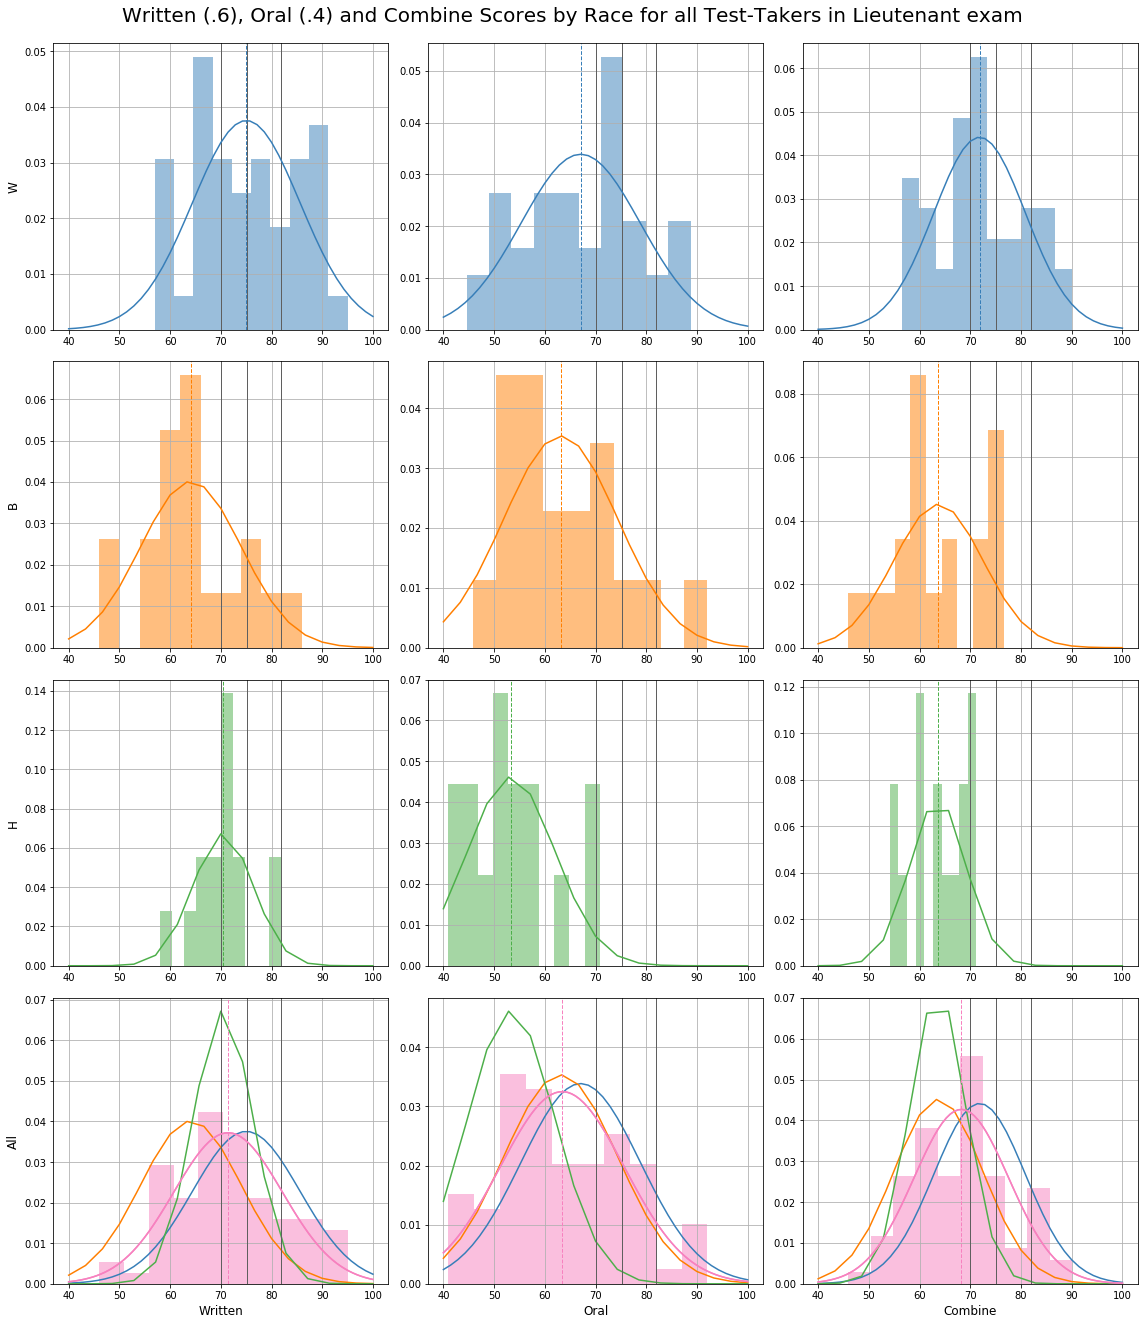

In [789]:
plt.rcParams["figure.figsize"] = [16,18]
plot(data,
     " ".join(["Written (.6), Oral (.4) and Combine Scores by Race for all Test-Takers in",position,"exam"]), 
     "".join(["../images/ff_orig_",position,"_race2score.png"]))

## Adverse impact ratio as a function of exam scaling

### 

In [790]:
scale = np.array(range(0,11))/10

ai_ratio_H, ai_ratio_B, ai_ratio_M = [], [], []
ai_ratio_2y_H, ai_ratio_2y_B, ai_ratio_2y_M = [], [], []
for i, q in enumerate(scale):
    df = pd.read_csv('../data/Firefighters.csv')  # load data set
    df = df[df['Position']==position]
    df['Combine'] = df.apply(lambda x: (q*x.Oral+(1-q)*x.Written), axis=1)
    df = get_features(df, thresh[position])
    summary = get_summary(df)
    ai_ratio_H.append(list(summary[summary.Race=='H']['Adverse_impact'])[0])
    ai_ratio_B.append(list(summary[summary.Race=='B']['Adverse_impact'])[0])
    ai_ratio_M.append(list(summary[summary.Race=='M']['Adverse_impact'])[0])
    ai_ratio_2y_H.append(list(summary[summary.Race=='H']['Adverse_impact_2y'])[0])
    ai_ratio_2y_B.append(list(summary[summary.Race=='B']['Adverse_impact_2y'])[0])
    ai_ratio_2y_M.append(list(summary[summary.Race=='M']['Adverse_impact_2y'])[0])
    

/home/laihoeev/anaconda3/envs/twml/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


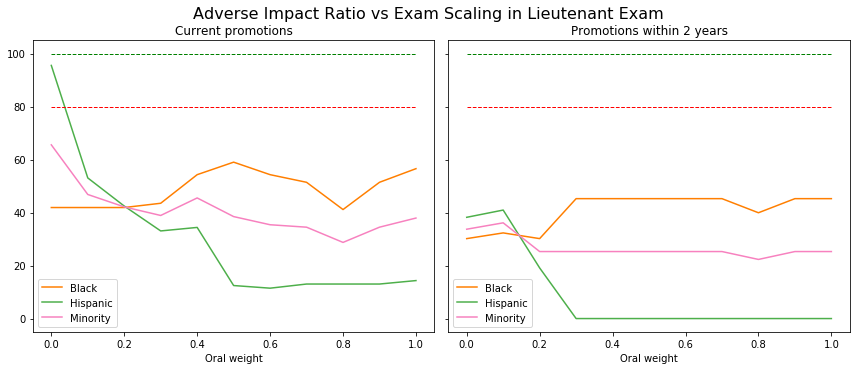

In [791]:
plt.rcParams["figure.figsize"] = [12,5]
plt.rcParams.update({'figure.autolayout': True})
fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].plot(scale, ai_ratio_B, label='Black', color=colors[1])
ax[0].plot(scale, ai_ratio_H, label='Hispanic', color=colors[2])
ax[0].plot(scale, ai_ratio_M, label='Minority', color=colors[3])
ax[0].set_title("Current promotions")
ax[0].set_xlabel("Oral weight")
ax[0].legend()
ax[0].plot([0, 1], [100, 100], 'g', linestyle='--', linewidth=1.0)
ax[0].plot([0, 1], [80, 80], 'r', linestyle='--', linewidth=1.0)

ax[1].plot(scale, ai_ratio_2y_B, label='Black', color=colors[1])
ax[1].plot(scale, ai_ratio_2y_H, label='Hispanic', color=colors[2])
ax[1].plot(scale, ai_ratio_2y_M, label='Minority', color=colors[3])
ax[1].set_title("Promotions within 2 years")
ax[1].set_xlabel("Oral weight")
ax[1].legend()
ax[1].plot([0, 1], [100, 100], 'g', linestyle='--', linewidth=1.0)
ax[1].plot([0, 1], [80, 80], 'r', linestyle='--', linewidth=1.0)

plt.suptitle("".join(["Adverse Impact Ratio vs Exam Scaling in ",position," Exam"]), fontsize=16, y=1.02)
plt.show()
fig.savefig("".join(["../images/ff_orig_",position,"_airatio.png"]), bbox_inches="tight")

## Implement Fairess Awareness

### IBM 360 Fairness Kit (Disparate Impact Removal)

In [534]:
protected = 'Majority'
df = data[['Oral','Written','Passed']].copy()
df[protected] = data.apply(lambda x: int(x['Race']=='W'), axis=1)

ds = StandardDataset(
        df=df, 
        label_name='Passed',favorable_classes=[1],
        protected_attribute_names=[protected], privileged_classes=[[1]],
        features_to_keep=['Oral','Written'])

#### Check for bias in the original data

In [554]:
from aif360.metrics import BinaryLabelDatasetMetric
priv, unpriv = [{protected: 1}], [{protected: 0}]
metric = BinaryLabelDatasetMetric(ds, privileged_groups=priv, unprivileged_groups=unpriv)

from aif360.explainers import MetricJSONExplainer
expl_json = MetricJSONExplainer(metric).disparate_impact()

import json
expl = json.loads(expl_json)
pd.set_option('display.max_colwidth', -1)
df_expl = pd.DataFrame([[key, expl[key]] for key in expl])
df_expl.style.set_properties(**{'text-align': 'left'})

,0,1
0,metric,Disparate Impact
1,message,Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.4552941176470588
2,numPositivePredictionsUnprivileged,9
3,numUnprivileged,34
4,numPositivePredictionsPrivileged,25
5,numPrivileged,43
6,description,Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.
7,ideal,The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.


#### Run Disparate Impact Remover 

In [792]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC as SVM

from tqdm import tqdm

    
def computeDIs(df, repair_levels):
    
    scaler = MinMaxScaler(copy=False) # Scale values between 0 and 1

    train = ds.copy()
    train.features = scaler.fit_transform(ds.features)
    index = train.feature_names.index(protected)

    DIs = []
    metrics = []
    features = []
    for level in tqdm(repair_levels):

        di = DisparateImpactRemover(repair_level=level)
        train_repd = di.fit_transform(train)
        
        X_tr = np.delete(train_repd.features, index, axis=1)
        y_tr = train_repd.labels.ravel()
        
        lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
        lmod.fit(X_tr, y_tr)
        
        train_repd_pred = train_repd.copy()
        train_repd_pred.labels = lmod.predict(X_tr)
        
        p = [{protected: 1}]
        u = [{protected: 0}]
        cm = BinaryLabelDatasetMetric(train_repd_pred, privileged_groups=p, unprivileged_groups=u)
        
        DIs.append(cm.disparate_impact())
        metrics.append(cm)
        features.append(train_repd_pred.features)
        
    return DIs, metrics, features


In [793]:
data[['Passed','Race','Oral','Written']].head(5)

,Passed,Race,Oral,Written
41,1,W,88.75,91
42,1,W,87.50,87
43,1,W,77.50,91
44,1,W,85.00,84
45,1,W,80.00,87


100%|██████████| 11/11 [00:00<00:00, 105.25it/s]
/home/laihoeev/anaconda3/envs/twml/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


[0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85 ]


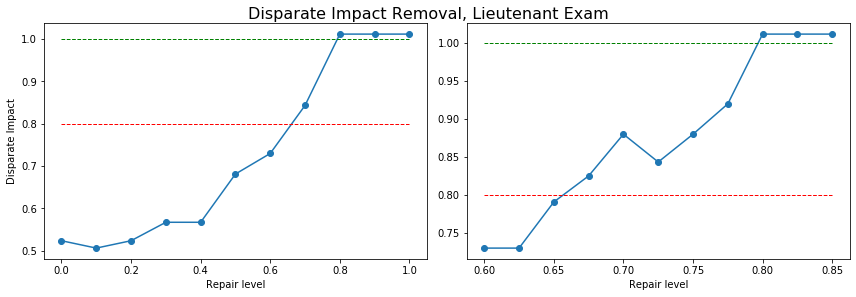

In [794]:
import matplotlib.pyplot as plt

repair_levels = np.linspace(0, 1, 11)
DIs,metrics,features = computeDIs(data, repair_levels)

plt.rcParams["figure.figsize"] = [12,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(repair_levels, DIs, marker='o')
ax[0].plot([0, 1], [1, 1], 'g', linestyle='--', linewidth=1.0)
ax[0].plot([0, 1], [0.8, 0.8], 'r', linestyle='--', linewidth=1.0)
ax[0].set_ylabel("Disparate Impact")
ax[0].set_xlabel("Repair level")

repair_levels = np.linspace(0.6, 0.85, 11)
DIs,metrics,features = computeDIs(data, repair_levels)

ax[1].plot(repair_levels, DIs, marker='o')
ax[1].plot([0.6, 0.85], [1, 1], 'g', linestyle='--', linewidth=1.0)
ax[1].plot([0.6, 0.85], [0.8, 0.8], 'r', linestyle='--', linewidth=1.0)
ax[1].set_xlabel("Repair level")
print(repair_levels)

plt.suptitle("".join(["Disparate Impact Removal, ",position," Exam"]), fontsize=16, y=1.02)
plt.show()
fig.savefig("".join(["../images/ff_orig_",position,"_diremoval.png"]), bbox_inches="tight")


#### Repair level 0.675

In [797]:
repair_levels = np.linspace(0.6, 0.85, 11)
DIs,metrics,features = computeDIs(data, [.675])
expl_json = MetricJSONExplainer(metrics[0]).disparate_impact()

import json
expl = json.loads(expl_json)
pd.set_option('display.max_colwidth', -1)
df_expl = pd.DataFrame([[key, expl[key]] for key in expl])
df_expl.style.set_properties(**{'text-align': 'left'})

100%|██████████| 1/1 [00:00<00:00, 90.14it/s]


,0,1
0,metric,Disparate Impact
1,message,Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.8248081841432225
2,numPositivePredictionsUnprivileged,15
3,numUnprivileged,34
4,numPositivePredictionsPrivileged,23
5,numPrivileged,43
6,description,Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.
7,ideal,The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.


In [801]:
q = .6
df = pd.DataFrame(features[0], columns=['Oral','Written','Passed'])
df['Written'] = df['Written']*100
df['Oral'] = df['Oral']*100
df['Combine'] = df.apply(lambda x: (1-q)*x['Oral']+q*x['Written'], axis=1)
df.head(5)

,Oral,Written,Passed,Combine
0,93.502439,77.551020,1.0,83.931588
1,78.048780,73.469388,1.0,75.301145
2,55.297561,77.551020,1.0,68.649637
3,74.809756,63.265306,1.0,67.883086
4,63.414634,73.469388,1.0,69.447486


In [802]:
print(min(df[df['Passed']==1]['Combine']))

18.446271777003478


In [803]:
print(max(df[df['Passed']==0]['Combine']))

65.35518168242908


## Generate random samples

To generate correlated normally distributed random samples, one can 
* first generate uncorrelated samples, and 
* then multiply them by a matrix C such that CCT=R, where R is the desired covariance matrix.

C can be created, for example, by using the Cholesky decomposition of R, or from the eigenvalues and eigenvectors of R. 
(Reference: https://scipy-cookbook.readthedocs.io/items/CorrelatedRandomSamples.html)

### Correlation matrix between Oral and Written

In [597]:
data.head(5)

,Top_k,Top_k_2y,Passed,Race,Oral,Written,Combine
41,True,True,1,W,88.75,91,90.1
42,True,True,1,W,87.50,87,87.2
43,True,True,1,W,77.50,91,85.6
44,True,True,1,W,85.00,84,84.4
45,True,True,1,W,80.00,87,84.2


In [807]:
# Correlation matrix between Oral and Written
df = data[["Oral", "Written"]].copy()
df["Majority"] = data.apply(lambda x: int(x['Race']=='W'), axis=1)
df.head(5)

,Oral,Written,Majority
41,88.75,91,1
42,87.50,87,1
43,77.50,91,1
44,85.00,84,1
45,80.00,87,1


In [831]:
from scipy.stats import truncnorm, norm
from scipy.linalg import cholesky

n_maj = 43
n_min = 34

def clean(x):
    return 100 if x>100 else x

def generate_samples(df, n, a, b):
    
    # Covariance matrix
    cov = df.cov()
    c = cholesky(cov, lower=True)
    
    x = []
    for col in df.columns:
        mean, std = df[col].mean(), df[col].std()
        print(mean, std, n, a, b)
        x.append(truncnorm.rvs(a, b, size=(1, int(1.1*n)), loc=mean, scale=std)[0])
    
    # Convert the data to correlated random variables. 
    output = np.dot(c/np.max(c), x).transpose()[:n]
    return output

columns = ["Oral", "Written"]
# Majority
samples_maj = pd.DataFrame(generate_samples(df[df['Majority']==1][columns], n_maj, 0, 100), columns=columns)
samples_maj['Majority'] = 1
print(samples_maj.info())
# Minority
samples_min = pd.DataFrame(generate_samples(df[df['Majority']==0][columns], n_min, 0, 100), columns=columns)
samples_min['Majority'] = 0
print(samples_min.info())
# Concat
samples = pd.concat([samples_maj, samples_min],ignore_index=True).apply(np.random.permutation, axis=0) 
samples = samples[samples["Written"]<=100][samples["Oral"]<=100]


67.07325581395348 11.914665776926277 43 0 100
75.02325581395348 10.747066869157557 43 0 100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
Oral        43 non-null float64
Written     43 non-null float64
Majority    43 non-null int64
dtypes: float64(2), int64(1)
memory usage: 1.1 KB
None
58.823235294117644 11.46517354282967 34 0 100
66.91176470588235 9.116643611046655 34 0 100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
Oral        34 non-null float64
Written     34 non-null float64
Majority    34 non-null int64
dtypes: float64(2), int64(1)
memory usage: 944.0 bytes
None


/home/laihoeev/anaconda3/envs/twml/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


/home/laihoeev/anaconda3/envs/twml/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


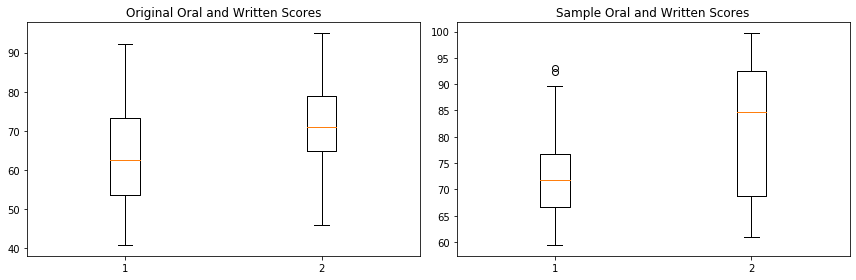

In [832]:
# Boxplots

fig, ax = plt.subplots(1,2)
ax[0].set_title('Original Oral and Written Scores')
ax[0].boxplot(data[["Oral", "Written"]].transpose())

ax[1].set_title('Sample Oral and Written Scores')
ax[1].boxplot(samples[["Oral", "Written"]].transpose())

plt.show()